# Hybridization of an exisitng WPP

## Evaluating the performance of a hybrid power plant using HyDesign

##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [1]:
# Detect if running in Kaggle
import os 
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
    mypaths = !python -c "import sysconfig; print(sysconfig.get_paths()['purelib'])"
    mypath = mypaths[0]
    !pip install trash-cli
    !trash $mypath/numpy*
    !pip install --upgrade numpy
    !pip install finitediff
    import os
    os.kill(os.getpid(), 9)

In [2]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git   

In [3]:
import os
import time
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from hydesign.hpp_assembly_hybridization import hpp_model
from hydesign.examples import examples_filepath

In [4]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0)
name = 'France_good_wind'
ex_site = examples_sites.loc[examples_sites.name == name]
longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]
input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]

existing_wpp_power_curve_xr_fn = examples_filepath + 'hybridization_existing_wpp/example_existing_wpp_power_curve.nc'
sim_pars_fn = examples_filepath + 'hybridization_existing_wpp/hpp_pars.yml'

hpp = hpp_model(
    latitude,
    longitude,
    altitude,
    num_batteries = 10,
    work_dir = './',
    sim_pars_fn = sim_pars_fn,
    input_ts_fn = input_ts_fn,
    existing_wpp_power_curve_xr_fn = existing_wpp_power_curve_xr_fn
)



Fixed parameters on the site
-------------------------------
longitude = -0.864258
latitude = 48.744116
altitude = 302.0


In [5]:
solar_MW = 100
surface_tilt = 30
surface_azimuth = 180
DC_AC_ratio =  1.2
b_P =  100 #MW
b_E_h = 7 #hours
cost_of_battery_P_fluct_in_peak_price_ratio = 10

x = [
# PV plant design
solar_MW,  surface_tilt, surface_azimuth, DC_AC_ratio,
# Energy storage & EMS price constrains
b_P, b_E_h, cost_of_battery_P_fluct_in_peak_price_ratio
]

##
### Evaluating the HPP model

In [6]:
start = time.time()

outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print(f'exec. time [min]:', (end - start)/60 )


Design:
---------------
solar_MW [MW]: 100.000
surface_tilt [deg]: 30.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.200
b_P [MW]: 100.000
b_E_h [h]: 7.000
cost_of_battery_P_fluct_in_peak_price_ratio: 10.000


NPV_over_CAPEX: -0.569
NPV [MEuro]: -306.066
IRR: 0.000
LCOE [Euro/MWh]: 108.206
CAPEX [MEuro]: 537.787
OPEX [MEuro]: 2.349
Wind CAPEX [MEuro]: 0.000
Wind OPEX [MEuro]: 1.809
PV CAPEX [MEuro]: 27.200
PV OPEX [MEuro]: 0.540
Batt CAPEX [MEuro]: 39.605
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 470.982
Shared Opex [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 369.408
GUF: 0.141
grid [MW]: 300.000
wind [MW]: 100.000
solar [MW]: 100.000
Battery Energy [MWh]: 700.000
Battery Power [MW]: 100.000
Total curtailment [GWh]: 0.000
Awpp [km2]: 1400.000
Apvp [km2]: 1.226
Plant area [km2]: 1400.000
Rotor diam [m]: 145.000
Hub height [m]: 100.000
Number of batteries used in lifetime: 2.000
Break-even PPA price [Euro/MWh]: 103.503
Capacity factor wind [-]: 0.311

exec. time [m


# Required existing farm file format

In [7]:
existing_wpp_power_curve_xr = xr.open_dataset(existing_wpp_power_curve_xr_fn)
existing_wpp_power_curve_xr


<xarray.Dataset>
Dimensions:          (ws: 53, wd: 361)
Coordinates:
  * ws               (ws) float64 0.0 0.5 1.0 1.5 2.0 ... 24.5 25.0 25.0 100.0
  * wd               (wd) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0 360.0
Data variables:
    wake_losses_eff  (ws, wd) float64 ...
    P_no_wake        (ws) float64 ...

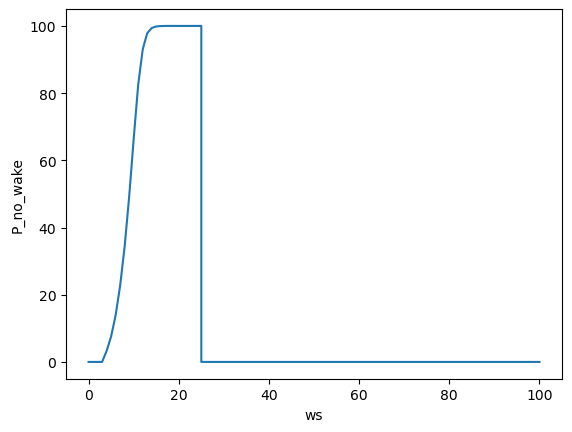

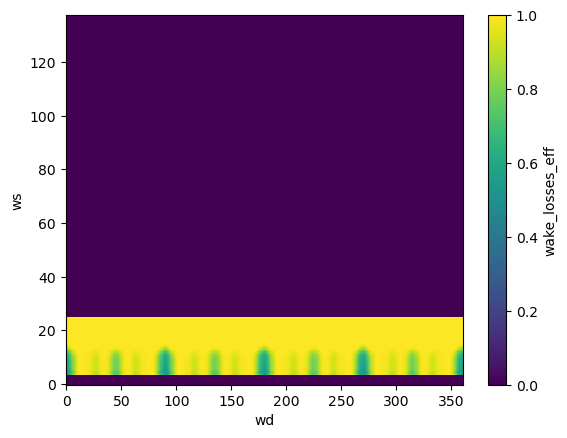

In [8]:


plt.figure()
existing_wpp_power_curve_xr.P_no_wake.plot(x='ws')

plt.figure()
existing_wpp_power_curve_xr.wake_losses_eff.plot(x='wd', y='ws')



In [9]:
wst = hpp.prob.get_val('existing_wpp.wst')
wdt = hpp.prob.get_val('existing_wpp.wdt')
wind_t = hpp.prob.get_val('existing_wpp.wind_t')

wst_ext = hpp.prob.get_val('existing_wpp_with_degradation.wst_ext')
wdt_ext = hpp.prob.get_val('existing_wpp_with_degradation.wdt_ext')
wind_t_ext_deg = hpp.prob.get_val('existing_wpp_with_degradation.wind_t_ext_deg')


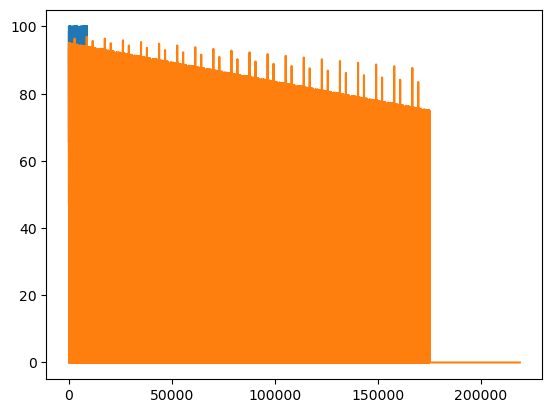

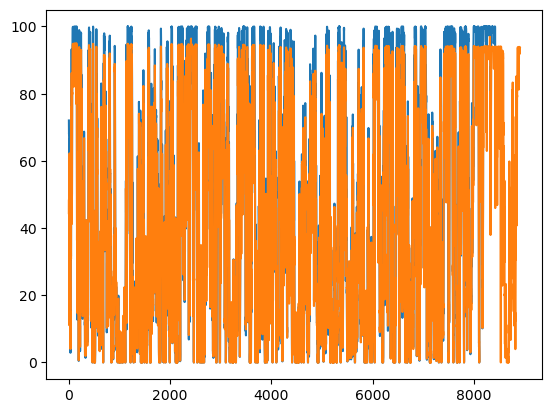

In [10]:
i_start=0
i_end=-1
plt.figure()
plt.plot(wind_t[i_start:i_end])
plt.plot(wind_t_ext_deg[i_start:i_end])

i_start = 1*365
i_end = i_start + 53*7*24
plt.figure()
plt.plot(wind_t[i_start:i_end])
plt.plot(wind_t_ext_deg[i_start:i_end])


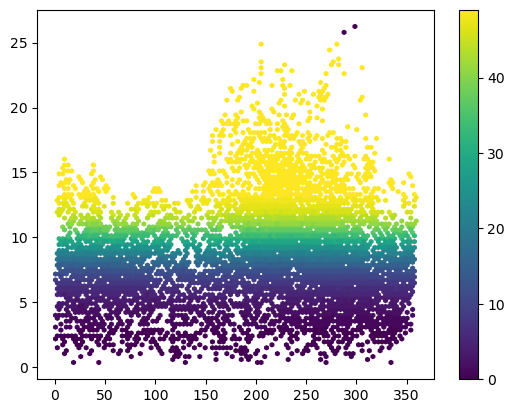

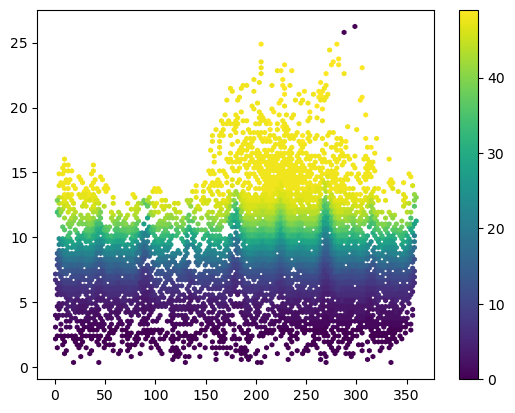

In [11]:

plt.figure()
plt.hexbin(x=wdt, y=wst, C=wind_t, bins=50)
plt.colorbar()

plt.figure()
plt.hexbin(x=wdt, y=wst, C=wind_t_ext_deg, bins=50)
plt.colorbar()